In [1]:
 import os
 os.environ['TF_USE_LEGACY_KERAS']='1'

In [2]:
pip install tf-keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


2025-04-16 14:46:13.577975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744814773.981128      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744814774.097461      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Load dataset
df = pd.read_csv("/kaggle/input/augmented-labeled/augmented_labeled.csv")  # Make sure the file is uploaded to your Colab environment

# Clean and shuffle
df = df[['tweet', 'class']].dropna().sample(frac=1).reset_index(drop=True)
# Desired samples per class
samples_per_class = 3000  # You can tune this for faster/slower training

# Group by class and sample
df_balanced = df.groupby('class').apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)

# Shuffle the final dataframe
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# One-hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(df_balanced['class'])
if labels.shape[1] == 1:
    labels = np.hstack([1 - labels, labels])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(df_balanced['tweet'], labels, test_size=0.1, random_state=42)

print(f"Sampled dataset size: {len(df_balanced)}")
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}")

# # One-hot encode labels
# lb = LabelBinarizer()
# labels = lb.fit_transform(df['class'])
# if labels.shape[1] == 1:  # For binary, convert to 2-column format
#     labels = np.hstack([1 - labels, labels])

# # Train-test split
# X_train, X_val, y_train, y_val = train_test_split(df['tweet'], labels, test_size=0.1, random_state=42)
# print(f"X_train type: {type(X_train)}, X_train[0]: {X_train[0]}")
# print(f"y_train shape: {y_train.shape}")

Sampled dataset size: 9000
Train size: 8100, Val size: 900


/tmp/ipykernel_31/2222251489.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class').apply(lambda x: x.sample(n=min(samples_per_class, len(x)), random_state=42)).reset_index(drop=True)


In [7]:
def get_preprocessing_layer(bert_model_url):
    if "small_bert" in bert_model_url:
        return hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")
    elif "albert" in bert_model_url:
        return hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_preprocess/3")
    elif "electra" in bert_model_url:
        return hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    else:  # base BERT
        return hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")


In [8]:
def cnn_head(sequence_output):
    x = layers.Conv1D(128, 5, activation='relu')(sequence_output)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    return layers.Dense(3, activation='softmax')(x)

def mlp_head(pooled_output):
    x = layers.Dense(256, activation='relu')(pooled_output)
    x = layers.Dropout(0.5)(x)
    return layers.Dense(3, activation='softmax')(x)


In [9]:
def build_model(bert_url, head_type='cnn'):
    text_input = layers.Input(shape=(), dtype=tf.string, name='text')
    
    # Load preprocessor and encoder
    preprocessor = get_preprocessing_layer(bert_url)
    encoder_inputs = preprocessor(text_input)

    encoder = hub.KerasLayer(bert_url, trainable=True, name='BERT_encoder')
    encoder_outputs = encoder(encoder_inputs)

    if head_type == 'cnn':
        # Use token-level embeddings (sequence_output): (batch, seq_len=30 or 64, hidden=512 or 768)
        x = encoder_outputs['sequence_output']

        # Conv Block 1
        x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
        # Conv Block 2
        x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
        # Global Max Pooling
        x = layers.GlobalMaxPooling1D()(x)
        # Fully Connected + Dropout
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        # Output
        output = layers.Dense(3, activation='softmax')(x)

    else:  # MLP
        # Use token-level embeddings (sequence_output), flatten for dense layers
        x = encoder_outputs['sequence_output']
        x = layers.Flatten()(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        output = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=text_input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [10]:
MODEL_URLS = {
    "bert": "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/3",
    "small_bert": "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-2-h-128-a-2/2",
    "albert": "https://tfhub.dev/google/albert_base/3",
    "electra": "https://tfhub.dev/google/electra_small/2"
}



🔧 Training BERT + CNN
Epoch 1/10
254/254 [==============================] - 289s 965ms/step - loss: 0.8052 - accuracy: 0.6181 - val_loss: 0.4909 - val_accuracy: 0.8222
Epoch 2/10
254/254 [==============================] - 242s 952ms/step - loss: 0.4579 - accuracy: 0.8390 - val_loss: 0.3934 - val_accuracy: 0.8644
Epoch 3/10
254/254 [==============================] - 242s 952ms/step - loss: 0.3244 - accuracy: 0.8893 - val_loss: 0.4077 - val_accuracy: 0.8467
Epoch 4/10
254/254 [==============================] - 241s 949ms/step - loss: 0.1988 - accuracy: 0.9357 - val_loss: 0.3890 - val_accuracy: 0.8922
Epoch 5/10
254/254 [==============================] - 242s 953ms/step - loss: 0.1323 - accuracy: 0.9604 - val_loss: 0.4441 - val_accuracy: 0.8900
Epoch 6/10
254/254 [==============================] - 242s 953ms/step - loss: 0.0983 - accuracy: 0.9735 - val_loss: 0.4244 - val_accuracy: 0.8878
Epoch 7/10
254/254 [==============================] - 241s 949ms/step - loss: 0.0666 - accuracy: 0.98

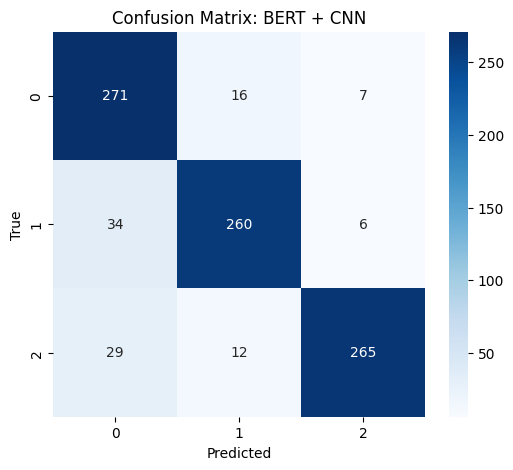

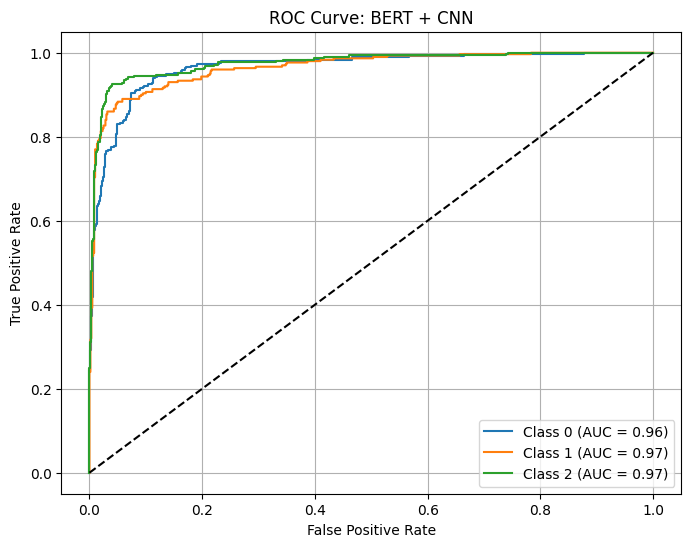


🔧 Training BERT + MLP
Epoch 1/10
254/254 [==============================] - 306s 1s/step - loss: 0.6143 - accuracy: 0.7391 - val_loss: 0.5005 - val_accuracy: 0.8033
Epoch 2/10
254/254 [==============================] - 257s 1s/step - loss: 0.3645 - accuracy: 0.8595 - val_loss: 0.4056 - val_accuracy: 0.8422
Epoch 3/10
254/254 [==============================] - 258s 1s/step - loss: 0.2329 - accuracy: 0.9156 - val_loss: 0.3479 - val_accuracy: 0.8711
Epoch 4/10
254/254 [==============================] - 258s 1s/step - loss: 0.1311 - accuracy: 0.9519 - val_loss: 0.3683 - val_accuracy: 0.8989
Epoch 5/10
254/254 [==============================] - 258s 1s/step - loss: 0.0884 - accuracy: 0.9694 - val_loss: 0.5150 - val_accuracy: 0.8944
Epoch 6/10
254/254 [==============================] - 258s 1s/step - loss: 0.0634 - accuracy: 0.9794 - val_loss: 0.4406 - val_accuracy: 0.8967
Epoch 7/10
254/254 [==============================] - 259s 1s/step - loss: 0.0345 - accuracy: 0.9899 - val_loss: 0.5578

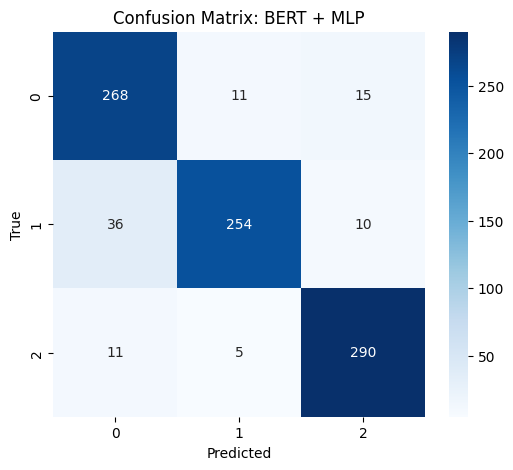

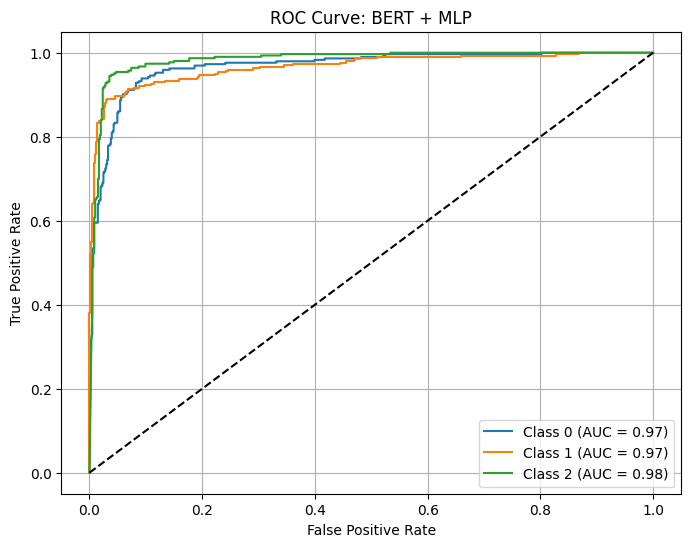


🔧 Training SMALL_BERT + CNN
Epoch 1/10
254/254 [==============================] - 30s 79ms/step - loss: 1.2232 - accuracy: 0.3678 - val_loss: 1.0353 - val_accuracy: 0.5333
Epoch 2/10
254/254 [==============================] - 12s 47ms/step - loss: 1.0425 - accuracy: 0.4593 - val_loss: 0.9159 - val_accuracy: 0.6111
Epoch 3/10
254/254 [==============================] - 11s 45ms/step - loss: 0.9102 - accuracy: 0.5701 - val_loss: 0.7531 - val_accuracy: 0.7122
Epoch 4/10
254/254 [==============================] - 11s 42ms/step - loss: 0.7752 - accuracy: 0.6577 - val_loss: 0.6281 - val_accuracy: 0.7711
Epoch 5/10
254/254 [==============================] - 11s 43ms/step - loss: 0.6901 - accuracy: 0.7157 - val_loss: 0.5673 - val_accuracy: 0.7833
Epoch 6/10
254/254 [==============================] - 10s 40ms/step - loss: 0.6219 - accuracy: 0.7559 - val_loss: 0.5292 - val_accuracy: 0.8033
Epoch 7/10
254/254 [==============================] - 11s 44ms/step - loss: 0.5645 - accuracy: 0.7764 - val

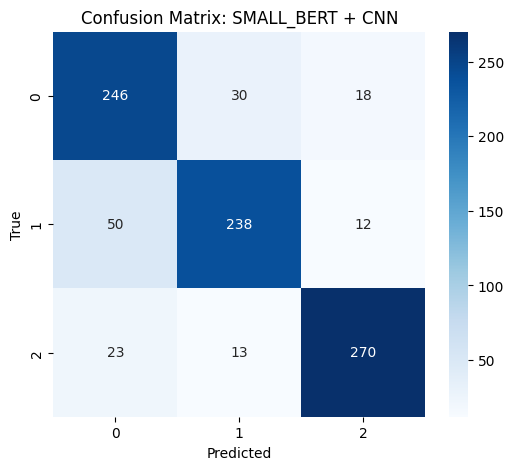

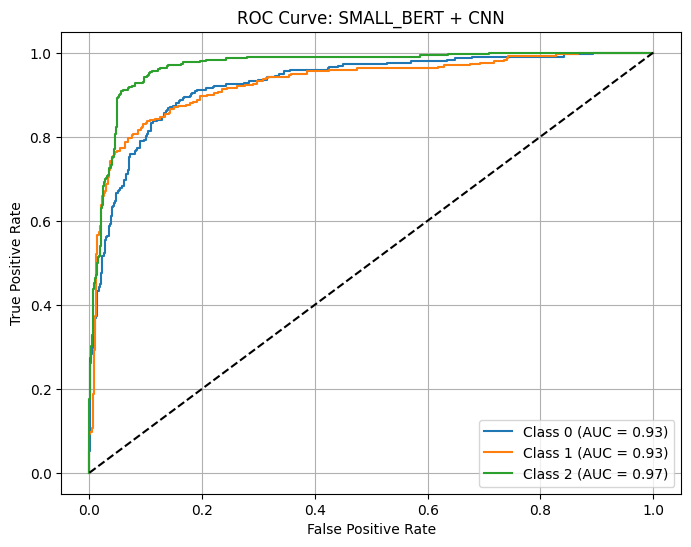


🔧 Training SMALL_BERT + MLP
Epoch 1/10
254/254 [==============================] - 29s 78ms/step - loss: 0.9890 - accuracy: 0.5331 - val_loss: 0.7249 - val_accuracy: 0.6956
Epoch 2/10
254/254 [==============================] - 12s 46ms/step - loss: 0.7655 - accuracy: 0.6616 - val_loss: 0.6527 - val_accuracy: 0.7478
Epoch 3/10
254/254 [==============================] - 11s 41ms/step - loss: 0.6637 - accuracy: 0.7164 - val_loss: 0.5751 - val_accuracy: 0.7711
Epoch 4/10
254/254 [==============================] - 10s 41ms/step - loss: 0.5981 - accuracy: 0.7568 - val_loss: 0.5355 - val_accuracy: 0.7956
Epoch 5/10
254/254 [==============================] - 11s 41ms/step - loss: 0.5536 - accuracy: 0.7746 - val_loss: 0.5191 - val_accuracy: 0.8033
Epoch 6/10
254/254 [==============================] - 10s 41ms/step - loss: 0.5119 - accuracy: 0.7964 - val_loss: 0.4831 - val_accuracy: 0.8133
Epoch 7/10
254/254 [==============================] - 10s 39ms/step - loss: 0.4628 - accuracy: 0.8125 - val

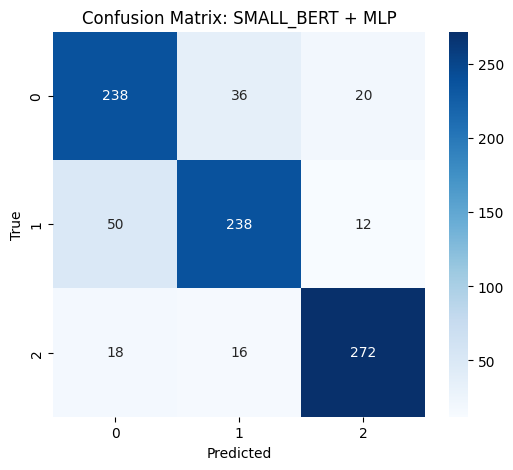

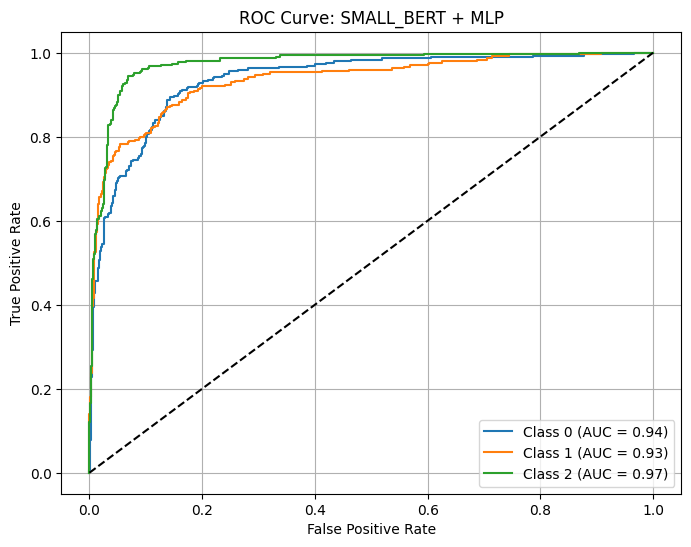


🔧 Training ALBERT + CNN


ValueError: Unknown signature default in https://tfhub.dev/google/albert_base/3 (available signatures: _SignatureMap({'tokens': <ConcreteFunction () -> Dict[['sequence_output', TensorSpec(shape=(None, None, 768), dtype=tf.float32, name=None)], ['pooled_output', TensorSpec(shape=(None, 768), dtype=tf.float32, name=None)]] at 0x7AA1F85418D0>, 'tokenization_info': <ConcreteFunction () -> Dict[['vocab_file', TensorSpec(shape=(), dtype=tf.string, name=None)], ['do_lower_case', TensorSpec(shape=(), dtype=tf.bool, name=None)]] at 0x7AA1E3EF7DD0>, 'mlm': <ConcreteFunction () -> Dict[['mlm_logits', TensorSpec(shape=(None, 30000), dtype=tf.float32, name=None)], ['sequence_output', TensorSpec(shape=(None, None, 768), dtype=tf.float32, name=None)], ['pooled_output', TensorSpec(shape=(None, 768), dtype=tf.float32, name=None)]] at 0x7AA617307490>})).

In [12]:
for model_name, url in MODEL_URLS.items():
    for head in ['cnn', 'mlp']:
        print(f"\n🔧 Training {model_name.upper()} + {head.upper()}")

        model = build_model(url, head_type=head)
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=32,
            verbose=1
        )

        # Predict on validation set
        y_pred_probs = model.predict(X_val)
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
        y_true_classes = np.argmax(y_val, axis=1)

        # Classification Report
        print(f"\n📄 Classification Report for {model_name.upper()} + {head.upper()}")
        print(classification_report(y_true_classes, y_pred_classes, digits=4))

        # Confusion Matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix: {model_name.upper()} + {head.upper()}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # ROC Curve (One vs Rest)
        fpr = {}
        tpr = {}
        roc_auc = {}

        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(8, 6))
        for i in range(3):
            plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"ROC Curve: {model_name.upper()} + {head.upper()}")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
